<h1>TD1 Machine Learning - MMVAI</h1>
<h3>Yann Terrom</h3>

<h2>Import</h2>

In [19]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

<h2>Part 1 : PCA</h2>

The goal of this TD is to understand the difference between PCA and Kernel based PCA

To perform a PCA based dimension reduction, we need:
<ul>
  <li>Compute the covariance matrix <b>C</b> of the original data <b>X</b>.</li>
  <li>Perform the eigendecomposition of the computed matrix.</li>
  <li>Sort the eigenvalues in decreasing order.</li>
  <li>Construct the projection matrix <b>W</b> with the first \(k\) eigenvalues.</li>
  <li><p>Transform the data into the projected space $X_{pca} = W^TX$.</p></li>
</ul>

<h3>Generate the data</h3>

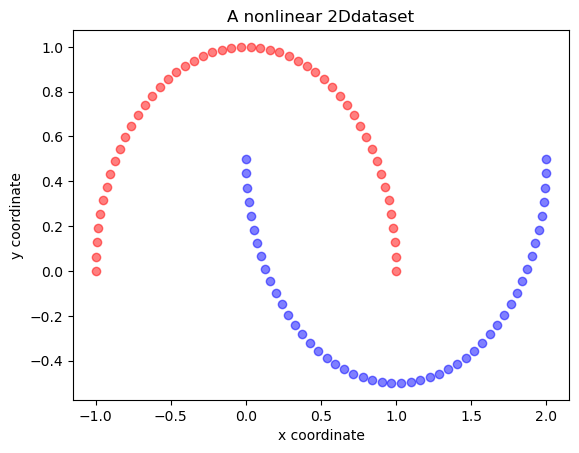

In [20]:
X, y = make_moons(n_samples=100, random_state=123)

plt.scatter(X[y==0, 0], X[y==0, 1], color='red', alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', alpha=0.5)

plt.title('A nonlinear 2Ddataset')
plt.ylabel('y coordinate')
plt.xlabel('x coordinate')
y = y.reshape((y.shape[0], 1))

<h3>TODO</h3>
<ul>
    <li>Perform PCA based reduction on this data</li>
    <li>Keep only the first leading eigen value</li>
    <li>Plot the resulting points</li>
</ul>

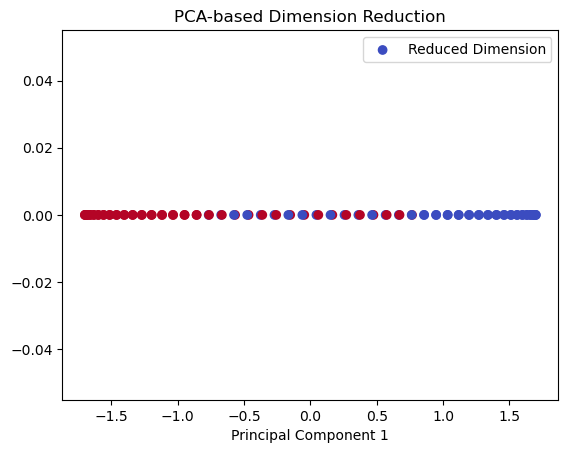

In [21]:
# Step 1: Compute the covariance matrix C
X_centered = (X - np.mean(X, axis=0)) / np.std(X, axis = 0)
C = np.cov(X_centered, rowvar=False)

# Step 2: Perform eigendecomposition
eigenvalues, eigenvectors = np.linalg.eigh(C)

# Step 3: Sort eigenvalues and eigenvectors
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

# Step 4: Construct projection matrix W using the first leading eigenvector
k = 1
W = eigenvectors[:, :k]

# Step 5: Transform data into reduced-dimensional space (X_{pca} = X.W)
X_pca = X_centered @ W

# Plot the resulting points
plt.scatter(X_pca[:, 0], np.zeros_like(X_pca), marker='o', c=y, cmap="coolwarm", label='Reduced Dimension')
plt.xlabel('Principal Component 1')
plt.title('PCA-based Dimension Reduction')
plt.legend()
plt.show()

<h3>TODO</h3>
<ul>
    <li>Perform linear classification using your favorite linear classifier</li>
</ul>

<p><strong>Implementation of the Linear Classifier</strong></p>

In [22]:
def initialisation(X):
    W = np.random.randn(X.shape[1], 1)
    b = np.random.randn(1)
    return (W, b)

def model(X, W, b):
    Z = X.dot(W + b)
    A = 1 / (1 + np.exp(-Z))
    return A

def log_loss(A, y):
    return 1 / len(y) * np.sum(-y * np.log(A) - (1 - y) * np.log(1 - A))

def gradients(A, X, y):
    dW = 1 / len(y) * np.dot(X.T, A - y)
    db = 1 / len(y) * np.sum(A - y)
    return (dW, db)

def update(dW, db, W, b, learning_rate):
    W -= learning_rate * dW
    b -= learning_rate * db 
    return (W, b)


def predict(X, W, b):
    A = model(X, W, b)
    return A >= 0.5

def perceptron(X, y, learning_rate = 0.1, n_iter = 100, loss = False):
    W, b = initialisation(X)
    Loss = []
    for i in range(n_iter):
        A = model(X, W, b)
        Loss.append(log_loss(A, y))
        dW, db = gradients(A, X, y)
        W, b = update(dW, db, W, b, learning_rate)
    
    y_pred = predict(X, W, b)
    if loss:
        return (W, b, Loss)
    return (W, b)

<p><strong>Training of the perceptron</strong></p>

In [23]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Create a linear classifier (Perceptron)
clf = perceptron(X_pca, y, loss = True)

<p><strong>Extract the Parameters</strong></p>

In [24]:
W, b, Loss = clf

<p><strong>Accuracy of the Perceptron</strong></p>

In [25]:
# Make predictions on the test set
y_pred = predict(X_test, W, b)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 80.00%


<p><strong>Plot the result</strong></p>

Text(0.5, 1.0, 'PCA-based Dimension Reduction')

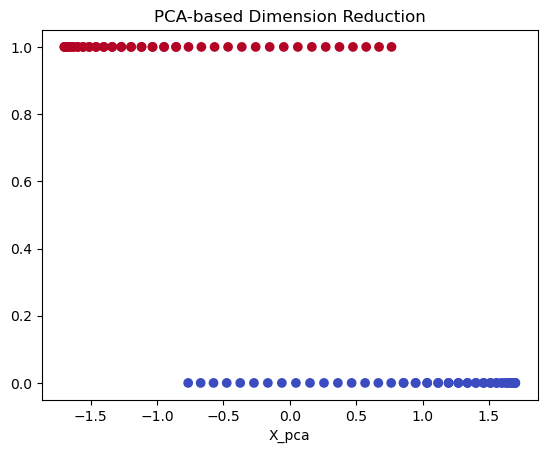

In [26]:
plt.figure()
plt.scatter(X_pca, y, c=y, cmap="coolwarm")
plt.xlabel('X_pca')
plt.title('PCA-based Dimension Reduction')

Text(0.5, 1.0, 'Learning Curve')

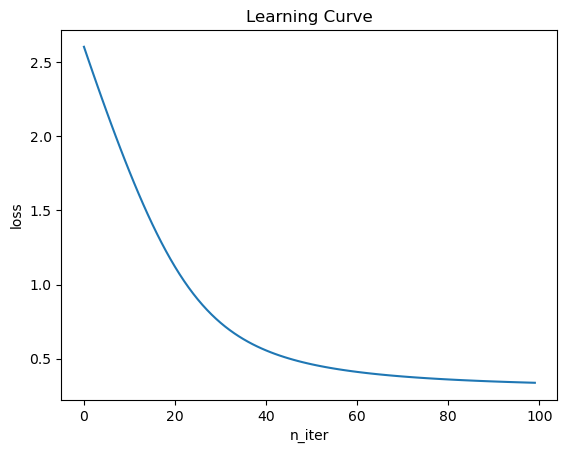

In [27]:
# Learning Curve
plt.figure()
plt.plot(Loss)
plt.ylabel("loss")
plt.xlabel("n_iter")
plt.title("Learning Curve")

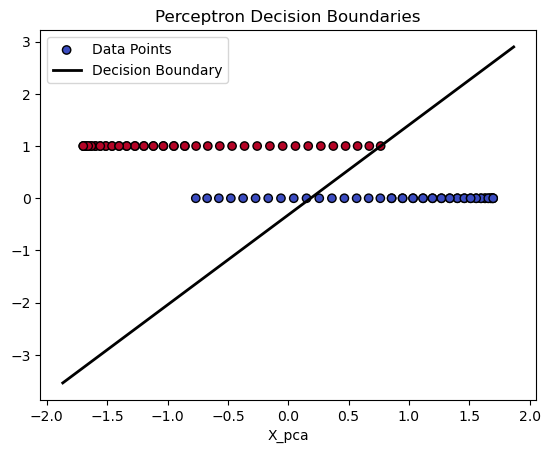

In [28]:

# Plot decision boundaries
plt.figure()

# Scatter plot of the data points
plt.scatter(X_pca, y, c=y, cmap="coolwarm", edgecolors='k', marker='o', label='Data Points')

# Plot decision boundaries
ax = plt.gca()
xlim = ax.get_xlim()
xx = np.linspace(xlim[0], xlim[1], 100)
yy = (-W[0] * xx - b)
plt.plot(xx, yy, color='black', linestyle='-', linewidth=2, label='Decision Boundary')

plt.xlabel('X_pca')
plt.title('Perceptron Decision Boundaries')
plt.legend()
plt.show()

<h2>Part 2 : Kernel PCA</h2>

Kernel functions and the kernel trick:

The basic idea to deal with inseparable data using linear classifiers is to project it onto a higher dimensional space where it becomes linearly separable. To do so, we:
<ul>
  <li>Compute the kernel matrix <b> K </b> using RBF kernel for instance $exp(−\gamma||x_i-x_j||^2)$ (exp(-g * abs(x_i - x_j) ²))</li>
  <li>Eigendecompose of the kernel matrix. <b> K </b> .</li>
  <li>to transform the data into the projected space.</li>
</ul>

<h3>TODO</h3>
<ul>
    <li>Perform KPCA based reduction on this data</li>
    <li>Keep only the first leading eigen value</li>
    <li>Plot the resulting points</li>

</ul>

<p><strong>Function for KPCA</strong></p>

In [29]:
def rbf_kernel(X, gamma):
    # Extract the number of samples
    n = X.shape[0]

    # Define the different matrix
    xxt = X @ X.T
    A = X @ X.T
    B = np.repeat(np.diag(xxt), n).reshape(n, n)

    # The return is an n x n matrix 
    return np.exp(-(B.T - 2*A + B) * gamma)

def kernel_pca(X, n_components, gamma):
    # Compute the RBF kernel matrix
    K = rbf_kernel(X, gamma)
    
    # Center the kernel matrix
    n_samples = K.shape[0]
    one_n = np.ones((n_samples, n_samples)) / n_samples
    K_centered = K - one_n @ K - K @ one_n + one_n @ K @ one_n
    
    # Perform eigendecomposition
    eigenvalues, eigenvectors = np.linalg.eigh(K_centered)
    
    # Sort eigenvalues and corresponding eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]
    
    # Keep only the first leading eigenvalues and corresponding eigenvectors
    K_pca_components = eigenvectors[:, :n_components]
    
    
    # Project the data into the reduced space
    X_kpca = K_pca_components.T @ K_centered.T
    
    return X_kpca.T

In [30]:
# Set kernel parameters
gamma_value = 0.5
n_components = 3

# Perform Kernel PCA
X_kpca = kernel_pca(X, n_components, gamma_value)

<h3>TODO</h3>
<ul>
    <li>Perform linear classification using your favorite linear classifier</li>
</ul>

<p><strong>Training the model</strong></p>

In [31]:
X_train_kpca, X_test_kpca, y_train_kpca, y_test_kpca = train_test_split(X_kpca, y, test_size=0.2, random_state=42)
clf_kpca = perceptron(X_train_kpca, y_train_kpca, loss = True)

<p><strong>Extract the parameters</strong></p>

In [32]:
W_kpca, b_kpca, Loss_kpca = clf_kpca

<p><strong>Compute the accuracy</strong></p>

In [33]:
# Make predictions on the test set
y_pred_kpca = predict(X_test_kpca, W_kpca, b_kpca)

# Evaluate accuracy
accuracy = accuracy_score(y_test_kpca, y_pred_kpca)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 75.00%


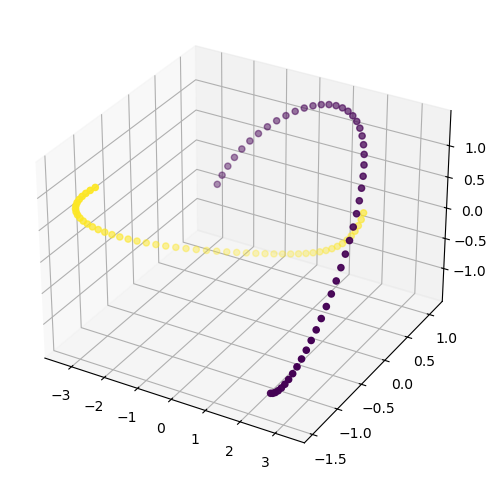

In [34]:
# Plot the resulting points and decision boundaries in 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_kpca[:, 0], X_kpca[:, 1], X_kpca[:, 2], c=y.ravel(), marker='o', label='Data Points')

plt.show()

<p><strong>Plot</strong></p>

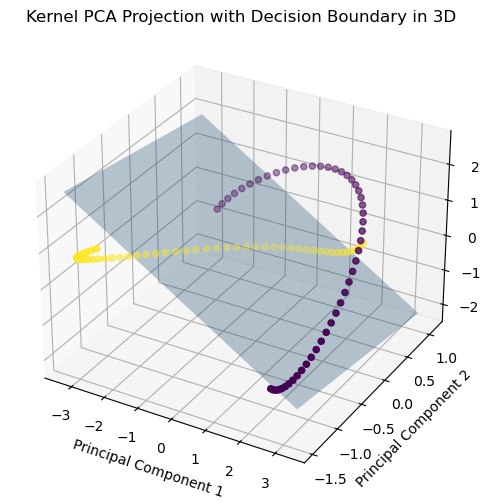

In [35]:
# Flatten y to a 1D array
y_flat = y.ravel()

# Plot the resulting points in 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_kpca[:, 0], X_kpca[:, 1], X_kpca[:, 2], c=y_flat, marker='o', label='Data Points')

# Plot the decision boundary
xx, yy = np.meshgrid(np.linspace(X_kpca[:, 0].min(), X_kpca[:, 0].max(), 100),
                     np.linspace(X_kpca[:, 1].min(), X_kpca[:, 1].max(), 100))
zz = -(W_kpca[0]*xx + W_kpca[1]*yy + b_kpca) / W_kpca[2]
ax.plot_surface(xx, yy, zz, alpha=0.3)

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('Kernel PCA Projection with Decision Boundary in 3D')

plt.show()

Text(0.5, 1.0, 'Learning Curve')

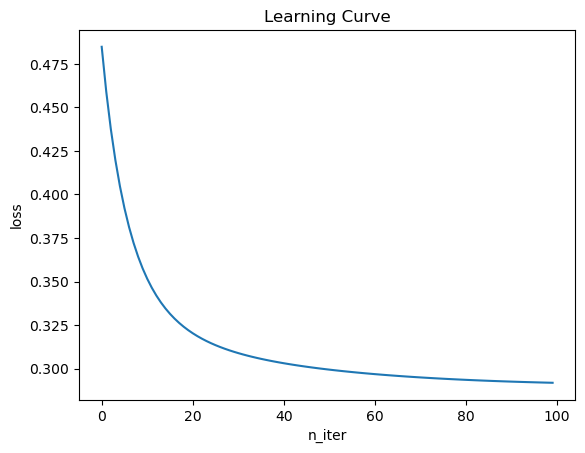

In [36]:
plt.figure()
plt.plot(Loss_kpca)
plt.ylabel("loss")
plt.xlabel("n_iter")
plt.title("Learning Curve")